In [59]:
import pandas as pd
import talib
from talib.abstract import *
import matplotlib.pyplot as plt

In [7]:
#installation worked only after installing the dependancy packages using (brew install ta-lib)
!pip install TA-Lib


  Using cached TA_Lib-0.4.32-cp311-cp311-macosx_14_0_arm64.whl


In [14]:
pwd

'/Users/abhisheksuga/Documents/Edu/thesis/gold/src'

In [20]:
df =  pd.read_csv("../data/gold.csv",header=0, index_col=0, parse_dates=True)

In [10]:
df.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2000-01-04,289.5,289.5,280.0,283.7,21621,USD
2000-01-05,283.7,285.0,281.0,282.1,25448,USD
2000-01-06,281.6,282.8,280.2,282.4,19055,USD
2000-01-07,282.5,284.5,282.0,282.9,11266,USD
2000-01-10,282.4,283.9,281.8,282.7,30603,USD


In [11]:
len(df)

5703

In [12]:
df.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
dtype: int64

In [13]:
df = df[df.Open !=0]
df = df[df.High !=0]
df = df[df.Low !=0]
df = df[df.Close !=0]

In [14]:
def Add_Lag(data,col,lag_list):
    
    position = data.columns.tolist().index(col)
    
    for lag in lag_list:
    
        col_val = data[col].shift(lag)

        col_name = col+'_lag:'+'{length}'.format(length=lag)

        data.insert(loc=position, column=col_name, value=col_val)
        

    return data

In [22]:
def Indicator(Data):

    data = pd.DataFrame()
    data['Open'] = Data['Open']
    data['High'] = Data['High']
    data['Low'] = Data['Low']
    data['Close'] = Data['Close']
    data['Volume'] = Data['Volume']


    Orginal_columns_names = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    #we apply indicators on one lage data
    Open = data['Open'].shift(1)
    High = data['High'].shift(1)
    Low = data['Low'].shift(1)
    Close = data['Close'].shift(1)
    Volume = data['Volume'].shift(1)

    Orginal_columns_values = {'open':Open,'high':High,'low':Low,'close':Close,'volume':Volume}
    #Gathering all functions in the Talib library
    Talib = talib.get_function_groups()
    Groups = list(Talib.keys())
    Indicators = []
    for group in Groups:
        for g in Talib[group]:
            Indicators.append(g)
    #As the following two functions are not returning an array with length of our data.shapep[0], we remove it
    Indicators.remove('MAVP')
    Indicators.remove('OBV')

    for indicator in Indicators:
        indicator = eval(indicator)
        
        #Here we have two types of functions(indicators,...):
        #The ones need just one column and the others which need more
        if len(indicator.output_names)==1:

            if list(indicator.get_input_names().values()) == ['close']:

                for col in Orginal_columns_names:

                    lagged_col = data[col].shift(1)

                    new_col = indicator(lagged_col)

                    name = indicator.info['name']

                    col_name = col+'_'+'{Name}'.format(Name=name)

                    data[col_name] = new_col

            
            else: #Functions need more than one features, e.g. [High, Low, Close, Open]

                name = indicator.info['name']

                inputs = list(indicator.get_input_names().values())

                if len(inputs)==2:

                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]])

                    data[name] = new_col
                    
                elif len(inputs)==3:

                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]],Orginal_columns_values[inputs[2]])
                    
                    data[name] = new_col

                elif len(inputs)==4:
                    
                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]],Orginal_columns_values[inputs[2]],Orginal_columns_values[inputs[3]])
                    
                    data[name] = new_col
    
    remove_col = []
    for col in data.columns:
        if float('-inf') in data[col].values: #Remove columns that have very large values
            remove_col.append(col)
        if data.tail(data.shape[0]-100)[col].isnull().values.any()==True: #remove columns that have nan values which are not cause of lags
            remove_col.append(col)
            
    remove_col = remove_col+Orginal_columns_names
    data.drop(remove_col,axis=1,inplace=True)

    return data



In [23]:
new_data = Indicator(df)

/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/2626521298.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = new_col
/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/2626521298.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = new_col
/var/folders/bz/q_7jbqjx7hj_vffhkj3cyl_m0000gn/T/ipykernel_11060/2626521298.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

In [31]:
len(new_data)

5703

In [26]:
def add_diff(data,col): #A simple type of features which calculate just the difference between sequential values in each columns

    position = data.columns.tolist().index(col)

    diff = [0,0]

    for i in range(1,data.shape[0]-1):

        difference = data[col][i] -  data[col][i-1]

        diff.append(difference)
    
    col_name = col+'_difference'

    data.insert(loc=position, column=col_name, value=diff)

    return data

In [36]:
df2 =  pd.read_csv("../data/data (1).csv")


In [37]:
df2.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
1713,2018-12-24,119.570000,120.139999,119.570000,120.019997,120.019997,9736400,239.039993,240.839996,234.270004,...,20.650000,21.090000,21.090000,60507000,9.49,9.52,9.28,9.29,9.29,21598200
1714,2018-12-26,120.620003,121.000000,119.570000,119.660004,119.660004,14293500,235.970001,246.179993,233.759995,...,20.530001,20.620001,20.620001,76365200,9.25,9.92,9.23,9.90,9.90,40978800
1715,2018-12-27,120.570000,120.900002,120.139999,120.570000,120.570000,11874400,242.570007,248.289993,238.960007,...,20.700001,20.969999,20.969999,52393000,9.59,9.65,9.37,9.62,9.62,36578700
1716,2018-12-28,120.800003,121.080002,120.720001,121.059998,121.059998,6864700,249.580002,251.399994,246.449997,...,20.570000,20.600000,20.600000,49835000,9.54,9.65,9.38,9.53,9.53,22803400
1717,2018-12-31,120.980003,121.260002,120.830002,121.250000,121.250000,8449400,249.559998,250.190002,247.470001,...,20.559999,21.090000,21.090000,53866600,9.63,9.71,9.44,9.66,9.66,28417400


In [66]:
df2.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'SP_open', 'SP_high', 'SP_low', 'SP_close', 'SP_Ajclose', 'SP_volume',
       'DJ_open', 'DJ_high', 'DJ_low', 'DJ_close', 'DJ_Ajclose', 'DJ_volume',
       'EG_open', 'EG_high', 'EG_low', 'EG_close', 'EG_Ajclose', 'EG_volume',
       'EU_Price', 'EU_open', 'EU_high', 'EU_low', 'EU_Trend', 'OF_Price',
       'OF_Open', 'OF_High', 'OF_Low', 'OF_Volume', 'OF_Trend', 'OS_Price',
       'OS_Open', 'OS_High', 'OS_Low', 'OS_Trend', 'SF_Price', 'SF_Open',
       'SF_High', 'SF_Low', 'SF_Volume', 'SF_Trend', 'USB_Price', 'USB_Open',
       'USB_High', 'USB_Low', 'USB_Trend', 'PLT_Price', 'PLT_Open', 'PLT_High',
       'PLT_Low', 'PLT_Trend', 'PLD_Price', 'PLD_Open', 'PLD_High', 'PLD_Low',
       'PLD_Trend', 'RHO_PRICE', 'USDI_Price', 'USDI_Open', 'USDI_High',
       'USDI_Low', 'USDI_Volume', 'USDI_Trend', 'GDX_Open', 'GDX_High',
       'GDX_Low', 'GDX_Close', 'GDX_Adj Close', 'GDX_Volume', 'USO_Open',
       'USO_Hig

In [67]:
df2['Date'] = pd.to_datetime(df2['Date'])

In [68]:
#checking corelation of adj close price with all the other features
corr = df2.corr().abs()['Adj Close'].sort_values(ascending = False)

In [69]:
corr

Close         1.000000
Adj Close     1.000000
High          0.999535
Low           0.999532
Open          0.998976
                ...   
PLD_Trend     0.026536
USB_Trend     0.025933
EU_Trend      0.019913
USDI_Trend    0.016641
PLT_Trend     0.011355
Name: Adj Close, Length: 81, dtype: float64

In [51]:
to_drop = corr[corr < 0.35]  #features to drop due to lesser correlation
to_drop

Volume         0.246778
SP_volume      0.241949
OF_Volume      0.225436
PLD_High       0.217490
PLD_Open       0.216426
PLD_Low        0.214919
PLD_Price      0.213179
USDI_Volume    0.205954
DJ_volume      0.155526
EG_volume      0.126586
RHO_PRICE      0.095782
OS_Trend       0.059510
OF_Trend       0.048205
SF_Trend       0.028100
PLD_Trend      0.026536
USB_Trend      0.025933
EU_Trend       0.019913
USDI_Trend     0.016641
PLT_Trend      0.011355
Name: Adj Close, dtype: float64

In [70]:
features_to_drop = list(to_drop.index)

In [71]:
data_new = df2.drop(features_to_drop, axis = 1)

In [72]:
data_new.head()

,Date,Open,High,Low,Close,Adj Close,SP_open,SP_high,SP_low,SP_close,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,123.029999,123.199997,121.989998,122.180000,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,122.230003,122.949997,121.300003,121.589996,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,122.059998,122.320000,120.029999,120.290001,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,122.180000,124.139999,120.370003,123.930000,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,123.930000,124.360001,122.750000,124.169998,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


In [73]:
data_new.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'SP_open',
       'SP_high', 'SP_low', 'SP_close', 'SP_Ajclose', 'DJ_open', 'DJ_high',
       'DJ_low', 'DJ_close', 'DJ_Ajclose', 'EG_open', 'EG_high', 'EG_low',
       'EG_close', 'EG_Ajclose', 'EU_Price', 'EU_open', 'EU_high', 'EU_low',
       'OF_Price', 'OF_Open', 'OF_High', 'OF_Low', 'OS_Price', 'OS_Open',
       'OS_High', 'OS_Low', 'SF_Price', 'SF_Open', 'SF_High', 'SF_Low',
       'SF_Volume', 'USB_Price', 'USB_Open', 'USB_High', 'USB_Low',
       'PLT_Price', 'PLT_Open', 'PLT_High', 'PLT_Low', 'USDI_Price',
       'USDI_Open', 'USDI_High', 'USDI_Low', 'GDX_Open', 'GDX_High', 'GDX_Low',
       'GDX_Close', 'GDX_Adj Close', 'GDX_Volume', 'USO_Open', 'USO_High',
       'USO_Low', 'USO_Close', 'USO_Adj Close', 'USO_Volume'],
      dtype='object')

In [74]:
data_new = data_new.set_index("Date")

In [55]:
data_new.head()

,Open,High,Low,Close,Adj Close,SP_open,SP_high,SP_low,SP_close,SP_Ajclose,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,123.029999,123.199997,121.989998,122.180000,105.441238,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,122.230003,122.949997,121.300003,121.589996,105.597549,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,122.059998,122.320000,120.029999,120.290001,104.468536,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,122.180000,124.139999,120.370003,123.930000,107.629784,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,123.930000,124.360001,122.750000,124.169998,107.838242,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


In [75]:
titles = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SP_open', 'SP_high', 'SP_low', 'SP_close',
          'SP_Ajclose','SP_volume','DJ_open', 'DJ_high' ]
feature_keys = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SP_open', 'SP_high', 'SP_low', 'SP_close',
                'SP_Ajclose', 'SP_volume','DJ_open', 'DJ_high']

colors = [ "blue","orange","green","red","purple","brown","pink","gray","olive", "cyan"]

date_time_key = "Date"

In [76]:
def visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()

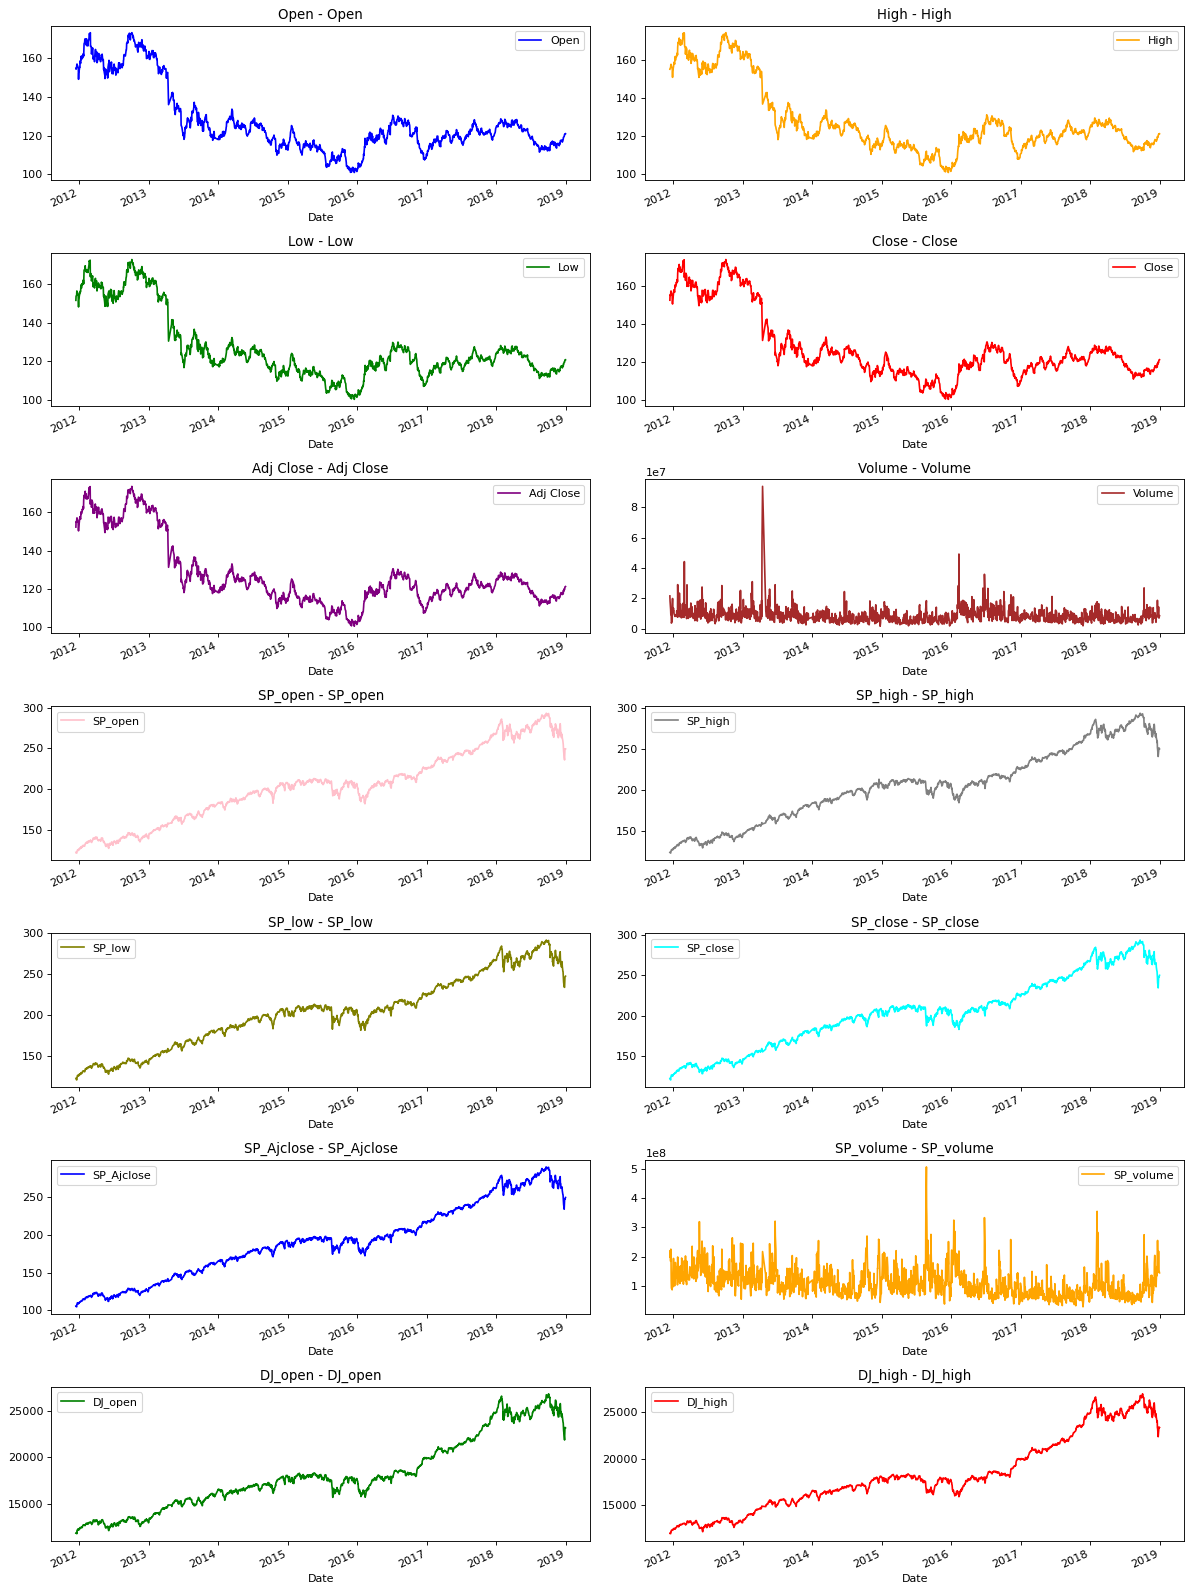

In [80]:
visualization(df2)